In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai import *
from fastai.vision import *

from fastai.callbacks import *
from fastai.vision.models.unet import _get_sfs_idxs, model_sizes, hook_outputs

import warnings
warnings.filterwarnings('ignore')

In [3]:
path = untar_data(URLs.PASCAL_2007)
path.ls()

[PosixPath('/home/hehao057/.fastai/data/pascal_2007/segmentation'),
 PosixPath('/home/hehao057/.fastai/data/pascal_2007/test.csv'),
 PosixPath('/home/hehao057/.fastai/data/pascal_2007/train.csv'),
 PosixPath('/home/hehao057/.fastai/data/pascal_2007/train.json'),
 PosixPath('/home/hehao057/.fastai/data/pascal_2007/test'),
 PosixPath('/home/hehao057/.fastai/data/pascal_2007/models'),
 PosixPath('/home/hehao057/.fastai/data/pascal_2007/test.json'),
 PosixPath('/home/hehao057/.fastai/data/pascal_2007/train'),
 PosixPath('/home/hehao057/.fastai/data/pascal_2007/valid.json')]

In [4]:
train_images, train_lbl_bbox = get_annotations(path/'train.json')
val_images, val_lbl_bbox = get_annotations(path/'valid.json')
images, lbl_bbox = train_images+val_images,train_lbl_bbox+val_lbl_bbox
img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o:img2bbox[o.name]

In [5]:
def get_data(bs, size):
    src = ObjectItemList.from_folder(path/'train')
    src = src.split_by_files(val_images)
    src = src.label_from_func(get_y_func)
    src = src.transform(get_transforms(), size=size, tfm_y=True,resize_method=ResizeMethod.SQUISH)
    return src.databunch(path=path, bs=bs, collate_fn=bb_pad_collate,num_workers=8).normalize(imagenet_stats)

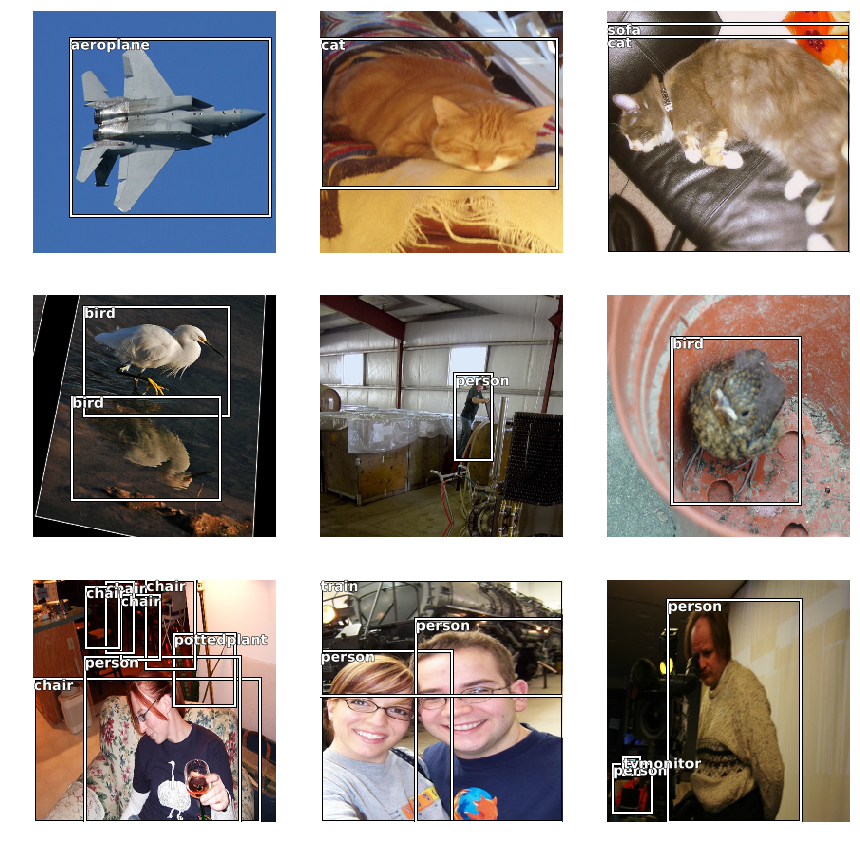

In [6]:
data = get_data(16,256)
data.show_batch(rows=3)

In [7]:
class LateralUpsampleMerge(nn.Module):
    "Merge the features coming from the downsample path (in `hook`) with the upsample path."
    def __init__(self, ch, ch_lat, hook):
        super().__init__()
        self.hook = hook
        self.conv_lat = conv2d(ch_lat, ch, ks=1, bias=True)
    
    def forward(self, x):
        return self.conv_lat(self.hook.stored) + F.interpolate(x, self.hook.stored.shape[-2:], mode='nearest')
    
class RetinaNet(nn.Module):
    "Implements RetinaNet from https://arxiv.org/abs/1708.02002"
    def __init__(self, encoder:nn.Module, n_classes, final_bias=0., chs=256, n_anchors=9, flatten=True):
        super().__init__()
        self.n_classes,self.flatten = n_classes,flatten
        imsize = (256,256)
        sfs_szs = model_sizes(encoder, size=imsize)
        sfs_idxs = list(reversed(_get_sfs_idxs(sfs_szs)))
        self.sfs = hook_outputs([encoder[i] for i in sfs_idxs])
        self.encoder = encoder
        self.c5top5 = conv2d(sfs_szs[-1][1], chs, ks=1, bias=True)
        self.c5top6 = conv2d(sfs_szs[-1][1], chs, stride=2, bias=True)
        self.p6top7 = nn.Sequential(nn.ReLU(), conv2d(chs, chs, stride=2, bias=True))
        self.merges = nn.ModuleList([LateralUpsampleMerge(chs, sfs_szs[idx][1], hook) 
                                     for idx,hook in zip(sfs_idxs[-2:-4:-1], self.sfs[-2:-4:-1])])
        self.smoothers = nn.ModuleList([conv2d(chs, chs, 3, bias=True) for _ in range(3)])
        self.classifier = self._head_subnet(n_classes, n_anchors, final_bias, chs=chs)
        self.box_regressor = self._head_subnet(4, n_anchors, 0., chs=chs)
        
    def _head_subnet(self, n_classes, n_anchors, final_bias=0., n_conv=4, chs=256):
        "Helper function to create one of the subnet for regression/classification."
        layers = [conv_layer(chs, chs, bias=True, norm_type=None) for _ in range(n_conv)]
        layers += [conv2d(chs, n_classes * n_anchors, bias=True)]
        layers[-1].bias.data.zero_().add_(final_bias)
        layers[-1].weight.data.fill_(0)
        return nn.Sequential(*layers)
    
    def _apply_transpose(self, func, p_states, n_classes):
        #Final result of the classifier/regressor is bs * (k * n_anchors) * h * w
        #We make it bs * h * w * n_anchors * k then flatten in bs * -1 * k so we can contenate
        #all the results in bs * anchors * k (the non flatten version is there for debugging only)
        if not self.flatten: 
            sizes = [[p.size(0), p.size(2), p.size(3)] for p in p_states]
            return [func(p).permute(0,2,3,1).view(*sz,-1,n_classes) for p,sz in zip(p_states,sizes)]
        else:
            return torch.cat([func(p).permute(0,2,3,1).contiguous().view(p.size(0),-1,n_classes) for p in p_states],1)
    
    def forward(self, x):
        c5 = self.encoder(x)
        p_states = [self.c5top5(c5.clone()), self.c5top6(c5)]
        p_states.append(self.p6top7(p_states[-1]))
        for merge in self.merges: p_states = [merge(p_states[0])] + p_states
        for i, smooth in enumerate(self.smoothers[:3]):
            p_states[i] = smooth(p_states[i])
        return [self._apply_transpose(self.classifier, p_states, self.n_classes), 
                self._apply_transpose(self.box_regressor, p_states, 4),
                [[p.size(2), p.size(3)] for p in p_states]]
    
    def __del__(self):
        if hasattr(self, "sfs"): self.sfs.remove()

In [8]:
def create_grid(size):
    "Create a grid of a given `size`."
    H, W = size if is_tuple(size) else (size,size)
    grid = FloatTensor(H, W, 2)
    linear_points = torch.linspace(-1+1/W, 1-1/W, W) if W > 1 else tensor([0.])
    grid[:, :, 1] = torch.ger(torch.ones(H), linear_points).expand_as(grid[:, :, 0])
    linear_points = torch.linspace(-1+1/H, 1-1/H, H) if H > 1 else tensor([0.])
    grid[:, :, 0] = torch.ger(linear_points, torch.ones(W)).expand_as(grid[:, :, 1])
    return grid.view(-1,2)

def show_anchors(ancs, size):
    _,ax = plt.subplots(1,1, figsize=(5,5))
    ax.set_xticks(np.linspace(-1,1, size[1]+1))
    ax.set_yticks(np.linspace(-1,1, size[0]+1))
    ax.grid()
    ax.scatter(ancs[:,1], ancs[:,0]) #y is first
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlim(-1,1)
    ax.set_ylim(1,-1) #-1 is top, 1 is bottom
    for i, (x, y) in enumerate(zip(ancs[:, 1], ancs[:, 0])): ax.annotate(i, xy = (x,y))

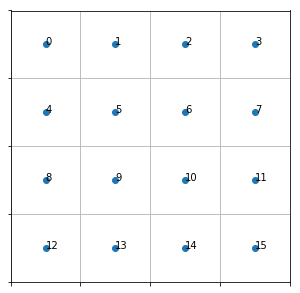

In [11]:
size = (4,4)
show_anchors(create_grid(size), size)

In [9]:
def create_anchors(sizes, ratios, scales, flatten=True):
    "Create anchor of `sizes`, `ratios` and `scales`."
    aspects = [[[s*math.sqrt(r), s*math.sqrt(1/r)] for s in scales] for r in ratios]
    aspects = torch.tensor(aspects).view(-1,2)
    anchors = []
    for h,w in sizes:
        #4 here to have the anchors overlap.
        sized_aspects = 4 * (aspects * torch.tensor([2/h,2/w])).unsqueeze(0)
        base_grid = create_grid((h,w)).unsqueeze(1)
        n,a = base_grid.size(0),aspects.size(0)
        ancs = torch.cat([base_grid.expand(n,a,2), sized_aspects.expand(n,a,2)], 2)
        anchors.append(ancs.view(h,w,a,4))
    return torch.cat([anc.view(-1,4) for anc in anchors],0) if flatten else anchors

In [13]:
ratios = [1/2,1,2]
scales = [1,2**(-1/3), 2**(-2/3)] 
#Paper used [1,2**(1/3), 2**(2/3)] but a bigger size (600) too, so the largest feature map gave anchors that cover less of the image.
sizes = [(2**i,2**i) for i in range(5)]
sizes.reverse() #Predictions come in the order of the smallest feature map to the biggest
anchors = create_anchors(sizes, ratios, scales)

In [14]:
anchors.size()

torch.Size([3069, 4])

In [10]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_color = 12
cmap = get_cmap(num_color)
color_list = [cmap(float(x)) for x in range(num_color)]

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)
    
    

In [11]:
def show_boxes(boxes):
    "Show the `boxes` (size by 4)"
    _, ax = plt.subplots(1,1, figsize=(5,5))
    ax.set_xlim(-1,1)
    ax.set_ylim(1,-1)
    for i, bbox in enumerate(boxes):
        bb = bbox.numpy()
        rect = [bb[1]-bb[3]/2, bb[0]-bb[2]/2, bb[3], bb[2]]
        draw_rect(ax, rect, color=color_list[i%num_color])
        draw_text(ax, [bb[1]-bb[3]/2,bb[0]-bb[2]/2], str(i), color=color_list[i%num_color])

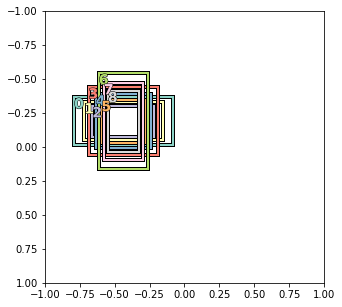

In [17]:

show_boxes(anchors[900:909])

In [12]:
def activ_to_bbox(acts, anchors, flatten=True):
    "Extrapolate bounding boxes on anchors from the model activations."
    if flatten:
        acts.mul_(acts.new_tensor([[0.1, 0.1, 0.2, 0.2]])) #Can't remember where those scales come from, but they help regularize
        centers = anchors[...,2:] * acts[...,:2] + anchors[...,:2]
        sizes = anchors[...,2:] * torch.exp(acts[...,:2])
        return torch.cat([centers, sizes], -1)
    else: return [activ_to_bbox(act,anc) for act,anc in zip(acts, anchors)]
    return res

In [19]:
size=(3,4)
anchors = create_grid(size)
anchors = torch.cat([anchors, torch.tensor([2/size[0],2/size[1]]).expand_as(anchors)], 1)
activations = torch.randn(size[0]*size[1], 4) * 0.1
bboxes = activ_to_bbox(activations, anchors)

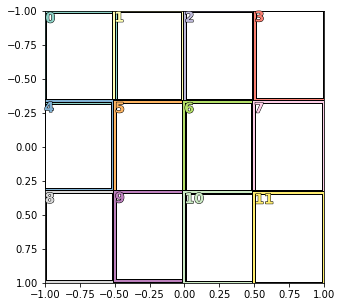

In [20]:
show_boxes(bboxes)


In [13]:
def cthw2tlbr(boxes):
    "Convert center/size format `boxes` to top/left bottom/right corners."
    top_left = boxes[:,:2] - boxes[:,2:]/2
    bot_right = boxes[:,:2] + boxes[:,2:]/2
    return torch.cat([top_left, bot_right], 1)

def intersection(anchors, targets):
    "Compute the sizes of the intersections of `anchors` by `targets`."
    ancs, tgts = cthw2tlbr(anchors), cthw2tlbr(targets)
    a, t = ancs.size(0), tgts.size(0)
    ancs, tgts = ancs.unsqueeze(1).expand(a,t,4), tgts.unsqueeze(0).expand(a,t,4)
    top_left_i = torch.max(ancs[...,:2], tgts[...,:2])
    bot_right_i = torch.min(ancs[...,2:], tgts[...,2:])
    sizes = torch.clamp(bot_right_i - top_left_i, min=0) 
    return sizes[...,0] * sizes[...,1]

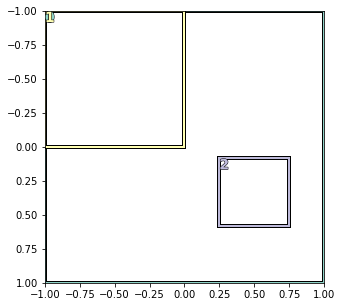

In [23]:
targets = torch.tensor([[0.,0.,2.,2.], [-0.5,-0.5,1.,1.], [1/3,0.5,0.5,0.5]])
show_boxes(targets)

In [24]:
intersection(anchors, targets)

tensor([[0.3333, 0.3333, 0.0000],
        [0.3333, 0.3333, 0.0000],
        [0.3333, 0.0000, 0.0000],
        [0.3333, 0.0000, 0.0000],
        [0.3333, 0.1667, 0.0000],
        [0.3333, 0.1667, 0.0000],
        [0.3333, 0.0000, 0.0625],
        [0.3333, 0.0000, 0.0625],
        [0.3333, 0.0000, 0.0000],
        [0.3333, 0.0000, 0.0000],
        [0.3333, 0.0000, 0.0625],
        [0.3333, 0.0000, 0.0625]])

In [14]:

def IoU_values(anchors, targets):
    "Compute the IoU values of `anchors` by `targets`."
    inter = intersection(anchors, targets)
    anc_sz, tgt_sz = anchors[:,2] * anchors[:,3], targets[:,2] * targets[:,3]
    union = anc_sz.unsqueeze(1) + tgt_sz.unsqueeze(0) - inter
    return inter/(union+1e-8)

In [26]:
IoU_values(anchors, targets)

tensor([[0.0833, 0.3333, 0.0000],
        [0.0833, 0.3333, 0.0000],
        [0.0833, 0.0000, 0.0000],
        [0.0833, 0.0000, 0.0000],
        [0.0833, 0.1429, 0.0000],
        [0.0833, 0.1429, 0.0000],
        [0.0833, 0.0000, 0.1200],
        [0.0833, 0.0000, 0.1200],
        [0.0833, 0.0000, 0.0000],
        [0.0833, 0.0000, 0.0000],
        [0.0833, 0.0000, 0.1200],
        [0.0833, 0.0000, 0.1200]])

In [15]:
def match_anchors(anchors, targets, match_thr=0.5, bkg_thr=0.4):
    "Match `anchors` to targets. -1 is match to background, -2 is ignore."
    matches = anchors.new(anchors.size(0)).zero_().long() - 2
    if targets.numel() == 0: return matches
    ious = IoU_values(anchors, targets)
    vals,idxs = torch.max(ious,1)
    matches[vals < bkg_thr] = -1
    matches[vals > match_thr] = idxs[vals > match_thr]
    #Overwrite matches with each target getting the anchor that has the max IoU.
    #vals,idxs = torch.max(ious,0)
    #If idxs contains repetition, this doesn't bug and only the last is considered.
    #matches[idxs] = targets.new_tensor(list(range(targets.size(0)))).long()
    return matches

In [28]:
match_anchors(anchors, targets)

tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [29]:
size=(3,4)
anchors = create_grid(size)
anchors = torch.cat([anchors, torch.tensor([2/size[0],2/size[1]]).expand_as(anchors)], 1)
activations = 0.1 * torch.randn(size[0]*size[1], 4)
bboxes = activ_to_bbox(activations, anchors)
match_anchors(anchors,bboxes)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [30]:
anchors = create_grid((2,2))
anchors = torch.cat([anchors, torch.tensor([1.,1.]).expand_as(anchors)], 1)
targets = anchors.clone()
anchors = torch.cat([anchors, torch.tensor([[-0.5,0.,1.,1.8]])], 0)
match_anchors(anchors,targets)

tensor([ 0,  1,  2,  3, -2])

In [16]:
def tlbr2cthw(boxes):
    "Convert top/left bottom/right format `boxes` to center/size corners."
    center = (boxes[:,:2] + boxes[:,2:])/2
    sizes = boxes[:,2:] - boxes[:,:2]
    return torch.cat([center, sizes], 1)

def bbox_to_activ(bboxes, anchors, flatten=True):
    "Return the target of the model on `anchors` for the `bboxes`."
    if flatten:
        t_centers = (bboxes[...,:2] - anchors[...,:2]) / anchors[...,2:] 
        t_sizes = torch.log(bboxes[...,2:] / anchors[...,2:] + 1e-8) 
        return torch.cat([t_centers, t_sizes], -1).div_(bboxes.new_tensor([[0.1, 0.1, 0.2, 0.2]]))
    else: return [activ_to_bbox(act,anc) for act,anc in zip(acts, anchors)]
    return res

In [17]:
def encode_class(idxs, n_classes):
    target = idxs.new_zeros(len(idxs), n_classes).float()
    mask = idxs != 0
    i1s = LongTensor(list(range(len(idxs))))
    target[i1s[mask],idxs[mask]-1] = 1
    return target

In [33]:
encode_class(LongTensor([1,2,0,1,3]),3)

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.]])

In [28]:
class RetinaNetFocalLoss(nn.Module):
    
    def __init__(self, gamma:float=2., alpha:float=0.25,  pad_idx:int=0, scales:Collection[float]=None, 
                 ratios:Collection[float]=None, reg_loss:LossFunction=F.smooth_l1_loss):
        super().__init__()
        self.gamma,self.alpha,self.pad_idx,self.reg_loss = gamma,alpha,pad_idx,reg_loss
        self.scales = ifnone(scales, [1,2**(-1/3), 2**(-2/3)])
        self.ratios = ifnone(ratios, [1/2,1,2])
        
    def _change_anchors(self, sizes:Sizes) -> bool:
        if not hasattr(self, 'sizes'): return True
        for sz1, sz2 in zip(self.sizes, sizes):
            if sz1[0] != sz2[0] or sz1[1] != sz2[1]: return True
        return False
    
    def _create_anchors(self, sizes:Sizes, device:torch.device):
        self.sizes = sizes
        self.anchors = create_anchors(sizes, self.ratios, self.scales).to(device)
    
    def _unpad(self, bbox_tgt, clas_tgt):
        try:
            i = torch.min(torch.nonzero(clas_tgt-self.pad_idx))
        except:
            i = 0
        return tlbr2cthw(bbox_tgt[i:]), clas_tgt[i:]-1+self.pad_idx
    
    def _focal_loss(self, clas_pred, clas_tgt):
        encoded_tgt = encode_class(clas_tgt, clas_pred.size(1))
        ps = torch.sigmoid(clas_pred.detach())
        weights = encoded_tgt * (1-ps) + (1-encoded_tgt) * ps
        alphas = (1-encoded_tgt) * self.alpha + encoded_tgt * (1-self.alpha)
        weights.pow_(self.gamma).mul_(alphas)
        clas_loss = F.binary_cross_entropy_with_logits(clas_pred, encoded_tgt, weights, reduction='sum')
        return clas_loss
        
    def _one_loss(self, clas_pred, bbox_pred, clas_tgt, bbox_tgt):
        bbox_tgt, clas_tgt = self._unpad(bbox_tgt, clas_tgt)
        matches = match_anchors(self.anchors, bbox_tgt)
        bbox_mask = matches>=0
        if bbox_mask.sum() != 0:
            bbox_pred = bbox_pred[bbox_mask]
            bbox_tgt = bbox_tgt[matches[bbox_mask]]
            bb_loss = self.reg_loss(bbox_pred, bbox_to_activ(bbox_tgt, self.anchors[bbox_mask]))
        else: bb_loss = 0.
        matches.add_(1)
        clas_tgt = clas_tgt + 1
        clas_mask = matches>=0
        clas_pred = clas_pred[clas_mask]
        clas_tgt = torch.cat([clas_tgt.new_zeros(1).long(), clas_tgt])
        clas_tgt = clas_tgt[matches[clas_mask]]
        return bb_loss + self._focal_loss(clas_pred, clas_tgt)/torch.clamp(bbox_mask.sum(), min=1.)
    
    def forward(self, output, bbox_tgts, clas_tgts):
        clas_preds, bbox_preds, sizes = output
        if self._change_anchors(sizes): self._create_anchors(sizes, clas_preds.device)
        n_classes = clas_preds.size(2)
        return sum([self._one_loss(cp, bp, ct, bt)
                    for (cp, bp, ct, bt) in zip(clas_preds, bbox_preds, clas_tgts, bbox_tgts)])/clas_tgts.size(0)

In [29]:
class SigmaL1SmoothLoss(nn.Module):

    def forward(self, output, target):
        reg_diff = torch.abs(target - output)
        reg_loss = torch.where(torch.le(reg_diff, 1/9), 4.5 * torch.pow(reg_diff, 2), reg_diff - 1/18)
        return reg_loss.mean()

In [30]:
ratios = [1/2,1,2]
scales = [1,2**(-1/3), 2**(-2/3)]
#scales = [1,2**(1/3), 2**(2/3)] for bigger size

In [31]:

encoder = create_body(models.resnet50, cut=-2)
model = RetinaNet(encoder, data.c, final_bias=-4)
crit = RetinaNetFocalLoss(scales=scales, ratios=ratios)
learn = Learner(data, model, loss_func=crit)

In [32]:

def retina_net_split(model):
    groups = [list(model.encoder.children())[:6], list(model.encoder.children())[6:]]
    return groups + [list(model.children())[1:]]

In [33]:
learn = learn.split(retina_net_split)

In [34]:
learn.freeze();

In [35]:
learn.lr_find()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


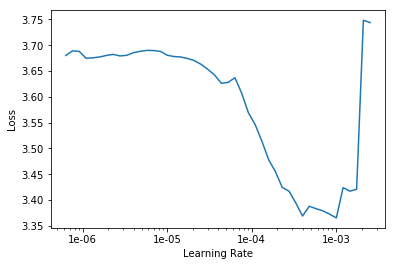

In [36]:
learn.recorder.plot()

In [37]:
learn.fit_one_cycle(5,1e-4)

epoch,train_loss,valid_loss,time
0,2.363646,2.298389,00:58
1,1.776373,1.861441,00:57
2,1.478424,1.550036,00:57
3,1.310089,1.476988,00:58
4,1.171039,1.418911,00:58


In [38]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-6, 5e-5))

epoch,train_loss,valid_loss,time
0,1.144839,1.404005,01:03
1,1.155229,1.428195,01:03
2,1.128557,1.399380,01:03
3,1.058545,1.316106,01:03
4,0.982579,1.190287,01:03
5,0.901498,1.155237,01:03
6,0.850686,1.146503,01:03
7,0.796808,1.126682,01:02
8,0.748968,1.087577,01:03
9,0.750444,1.097167,01:03


In [39]:
!pwd 

/home/hehao057/6411/nbs


In [40]:
learn.save('/home/hehao057/6411/weights/res50-256')

In [41]:
learn.data = get_data(8,384)

In [42]:
learn.freeze()
learn.lr_find()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


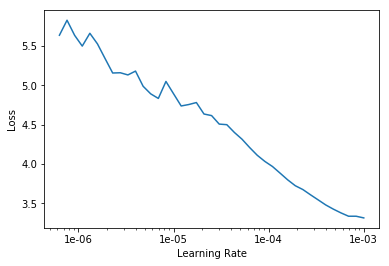

In [43]:
learn.recorder.plot()

In [44]:
learn.fit_one_cycle(5, 1e-4)

epoch,train_loss,valid_loss,time
0,1.106034,1.167343,02:27
1,1.095547,1.250065,02:29
2,0.922537,1.076939,02:29
3,0.847028,0.971952,02:29
4,0.736759,0.934643,02:28


In [45]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-6, 5e-5))

epoch,train_loss,valid_loss,time
0,0.722381,0.970572,02:40
1,0.771434,0.920207,02:40
2,0.763633,1.000372,02:39
3,0.740878,0.919353,02:39
4,0.674700,0.908947,02:39
5,0.599723,0.863407,02:40
6,0.584092,0.857950,02:37
7,0.536388,0.845743,02:36
8,0.492987,0.826744,02:36
9,0.492650,0.829909,02:36


In [46]:
learn.save('/home/hehao057/6411/weights/res50-384')

In [89]:
def unpad(tgt_bbox, tgt_clas, pad_idx=0):
    i = torch.min(torch.nonzero(tgt_clas-pad_idx))
    return tlbr2cthw(tgt_bbox[i:]), tgt_clas[i:]-1+pad_idx

def nms(boxes, scores, thresh=0.3):
    idx_sort = scores.argsort(descending=True)
    boxes, scores = boxes[idx_sort], scores[idx_sort]
    to_keep, indexes = [], torch.LongTensor(range_of(scores))
    while len(scores) > 0:
        to_keep.append(idx_sort[indexes[0]])
        iou_vals = IoU_values(boxes, boxes[:1]).squeeze()
        mask_keep = iou_vals < thresh
        if len(mask_keep.nonzero()) == 0: break
        boxes, scores, indexes = boxes[mask_keep], scores[mask_keep], indexes[mask_keep]
    return LongTensor(to_keep)

def process_output(output, i, detect_thresh=0.25):
    clas_pred,bbox_pred,sizes = output[0][i], output[1][i], output[2]
    anchors = create_anchors(sizes, ratios, scales).to(clas_pred.device)
    bbox_pred = activ_to_bbox(bbox_pred, anchors)
    clas_pred = torch.sigmoid(clas_pred)
    detect_mask = clas_pred.max(1)[0] > detect_thresh
    bbox_pred, clas_pred = bbox_pred[detect_mask], clas_pred[detect_mask]
    bbox_pred = tlbr2cthw(torch.clamp(cthw2tlbr(bbox_pred), min=-1, max=1))    
    if clas_pred.numel() == 0: return [],[],[]
    scores, preds = clas_pred.max(1)
    return bbox_pred, scores, preds

def show_preds(img, output, idx, detect_thresh=0.25, classes=None, ax=None):
    bbox_pred, scores, preds = process_output(output, idx, detect_thresh)
    if len(scores) != 0:
        to_keep = nms(bbox_pred, scores)
        bbox_pred, preds, scores = bbox_pred[to_keep].cpu(), preds[to_keep].cpu(), scores[to_keep].cpu()
        t_sz = torch.Tensor([*img.size])[None].float()
        bbox_pred[:,:2] = bbox_pred[:,:2] - bbox_pred[:,2:]/2
        bbox_pred[:,:2] = (bbox_pred[:,:2] + 1) * t_sz/2
        bbox_pred[:,2:] = bbox_pred[:,2:] * t_sz
        bbox_pred = bbox_pred.long()
    if ax is None: _, ax = plt.subplots(1,1)
    img.show(ax=ax)
    for bbox, c, scr in zip(bbox_pred, preds, scores):
        txt = str(c.item()) if classes is None else classes[c.item()+1]
        draw_rect(ax, [bbox[1],bbox[0],bbox[3],bbox[2]])
        draw_text(ax, (bbox[1],bbox[0]),txt=f'{txt} {scr:.2f}')

def show_results(learn, start=0, n=5, detect_thresh=0.35, figsize=(10,25)):
    x,y = learn.data.one_batch(DatasetType.Valid, cpu=False)
    with torch.no_grad():
        z = learn.model.eval()(x)
    _,axs = plt.subplots(n, 2, figsize=figsize)
    for i in range(n):
        img,bbox = learn.data.valid_ds[start+i]
        img.show(ax=axs[i,0], y=bbox)
        show_preds(img, z, start+i, detect_thresh=detect_thresh, classes=learn.data.classes, ax=axs[i,1])



In [48]:
def get_predictions(output, idx, detect_thresh=0.05):
    bbox_pred, scores, preds = process_output(output, idx, detect_thresh)
    if len(scores) == 0: return [],[],[]
    to_keep = nms(bbox_pred, scores)
    return bbox_pred[to_keep], preds[to_keep], scores[to_keep]

def compute_ap(precision, recall):
    "Compute the average precision for `precision` and `recall` curve."
    recall = np.concatenate(([0.], list(recall), [1.]))
    precision = np.concatenate(([0.], list(precision), [0.]))
    for i in range(len(precision) - 1, 0, -1):
        precision[i - 1] = np.maximum(precision[i - 1], precision[i])
    idx = np.where(recall[1:] != recall[:-1])[0]
    ap = np.sum((recall[idx + 1] - recall[idx]) * precision[idx + 1])
    return ap

def compute_class_AP(model, dl, n_classes, iou_thresh=0.5, detect_thresh=0.35, num_keep=100):
    tps, clas, p_scores = [], [], []
    classes, n_gts = LongTensor(range(n_classes)),torch.zeros(n_classes).long()
    with torch.no_grad():
        for input,target in progress_bar(dl):
            output = model(input)
            for i in range(target[0].size(0)):
                bbox_pred, preds, scores = get_predictions(output, i, detect_thresh)
                tgt_bbox, tgt_clas = unpad(target[0][i], target[1][i])
                if len(bbox_pred) != 0 and len(tgt_bbox) != 0:
                    ious = IoU_values(bbox_pred, tgt_bbox)
                    max_iou, matches = ious.max(1)
                    detected = []
                    for i in range_of(preds):
                        if max_iou[i] >= iou_thresh and matches[i] not in detected and tgt_clas[matches[i]] == preds[i]:
                            detected.append(matches[i])
                            tps.append(1)
                        else: tps.append(0)
                    clas.append(preds.cpu())
                    p_scores.append(scores.cpu())
                n_gts += (tgt_clas.cpu()[:,None] == classes[None,:]).sum(0)
    tps, p_scores, clas = torch.tensor(tps), torch.cat(p_scores,0), torch.cat(clas,0)
    fps = 1-tps
    idx = p_scores.argsort(descending=True)
    tps, fps, clas = tps[idx], fps[idx], clas[idx]
    aps = []
    #return tps, clas
    for cls in range(n_classes):
        tps_cls, fps_cls = tps[clas==cls].float().cumsum(0), fps[clas==cls].float().cumsum(0)
        if tps_cls.numel() != 0 and tps_cls[-1] != 0:
            precision = tps_cls / (tps_cls + fps_cls + 1e-8)
            recall = tps_cls / (n_gts[cls] + 1e-8)
            aps.append(compute_ap(precision, recall))
        else: aps.append(0.)
    return aps

In [51]:
L = compute_class_AP(learn.model, data.valid_dl, data.c-1)

In [52]:
for ap,cl in zip(L, data.classes[1:]): print(f'{cl}: {ap:.6f}') #0.5

aeroplane: 0.478901
bicycle: 0.264757
bird: 0.288628
boat: 0.186630
bottle: 0.059414
bus: 0.350375
car: 0.372012
cat: 0.635105
chair: 0.057392
cow: 0.265061
diningtable: 0.328756
dog: 0.438304
horse: 0.423385
motorbike: 0.362328
person: 0.236585
pottedplant: 0.042975
sheep: 0.270097
sofa: 0.315039
train: 0.592381
tvmonitor: 0.231808


In [53]:
L = compute_class_AP(learn.model, data.valid_dl, data.c-1, iou_thresh=0.75)

In [54]:
for ap,cl in zip(L, data.classes[1:]): print(f'{cl}: {ap:.6f}') #0.75

aeroplane: 0.083743
bicycle: 0.024911
bird: 0.033719
boat: 0.021947
bottle: 0.006487
bus: 0.070096
car: 0.064566
cat: 0.070699
chair: 0.001449
cow: 0.031912
diningtable: 0.033799
dog: 0.060384
horse: 0.047187
motorbike: 0.063821
person: 0.013139
pottedplant: 0.003894
sheep: 0.018936
sofa: 0.072737
train: 0.126126
tvmonitor: 0.014662


In [57]:
L = compute_class_AP(learn.model, data.valid_dl, data.c-1, iou_thresh=0.5,detect_thresh=0.25)

In [58]:
for ap,cl in zip(L, data.classes[1:]): print(f'{cl}: {ap:.6f}') #0.5:0.25

aeroplane: 0.493653
bicycle: 0.275538
bird: 0.304482
boat: 0.194897
bottle: 0.063741
bus: 0.353088
car: 0.388007
cat: 0.647231
chair: 0.061888
cow: 0.277800
diningtable: 0.334395
dog: 0.441668
horse: 0.433862
motorbike: 0.368332
person: 0.253043
pottedplant: 0.050850
sheep: 0.278081
sofa: 0.321597
train: 0.614240
tvmonitor: 0.240482


In [62]:
np.mean(L)

0.3198437544543741

In [106]:
gc.collect()

81

In [ ]:
output = []
learn.model.eval()
with torch.no_grad():
    for xb, yb in data.valid_dl:
        output.append(learn.model(xb))

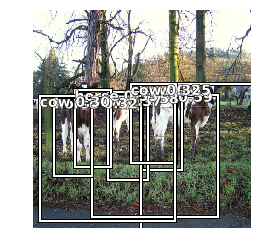

In [101]:
idx = 11
img = data.valid_ds[idx][0]
show_preds(img, output[idx], idx, detect_thresh=0.3, classes=data.classes)

In [8]:
model_sizes(encoder, size=(256,256))

[torch.Size([1, 64, 128, 128]),
 torch.Size([1, 64, 128, 128]),
 torch.Size([1, 64, 128, 128]),
 torch.Size([1, 64, 64, 64]),
 torch.Size([1, 256, 64, 64]),
 torch.Size([1, 512, 32, 32]),
 torch.Size([1, 1024, 16, 16]),
 torch.Size([1, 2048, 8, 8])]

In [9]:
anc_grids = [32,16,8,4,2] # change according to the last 3, aka 32, 16, 8
anc_zooms = [0.75, 1., 1.3]
anc_ratios = [(1., 1.), (1., 0.5), (0.5, 1.)]

anchor_scales = [(anz*i,anz*j) for anz in anc_zooms 
                                    for (i,j) in anc_ratios]
k = len(anchor_scales)
anc_offsets = [2/(o*2) for o in anc_grids] #2 is the h,w in fastai 1.0 (-1,1)
anc_x = np.concatenate([np.repeat(np.linspace(ao-1, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_y = np.concatenate([np.tile(np.linspace(ao-1, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)
anc_sizes = np.concatenate([np.array([[2*o/ag,2*p/ag] 
              for i in range(ag*ag) for o,p in anchor_scales])
                 for ag in anc_grids]) #2/grid * scale,2 is the h,w in fastai 1.0
grid_sizes = tensor(np.concatenate([np.array([ 1/ag 
              for i in range(ag*ag) for o,p in anchor_scales])
                  for ag in anc_grids])).unsqueeze(1) *2 #again fastai 1.0 h,w is 2
anchors = tensor(np.concatenate([anc_ctrs, anc_sizes], axis=1)).float()

In [10]:
class LateralUpsampleMerge(nn.Module):

    def __init__(self, ch, ch_lat, hook):
        super().__init__()
        self.hook = hook
        self.conv_lat = conv2d(ch_lat, ch, ks=1, bias=True)

    def forward(self, x):
        return self.conv_lat(self.hook.stored) + F.interpolate(x, scale_factor=2)


class RetinaNet(nn.Module):
    "Implements RetinaNet from https://arxiv.org/abs/1708.02002"

    def __init__(self, encoder: nn.Module, n_classes, final_bias:float=0.,  n_conv:float=4,
                 chs=256, n_anchors=9, flatten=True, sizes=None):
        super().__init__()
        self.n_classes, self.flatten = n_classes, flatten
        imsize = (256, 256)
        self.sizes = sizes
        sfs_szs, x, hooks = self._model_sizes(encoder, size=imsize)
        sfs_idxs = _get_sfs_idxs(sfs_szs)
        self.encoder = encoder
        self.c5top5 = conv2d(sfs_szs[-1][1], chs, ks=1, bias=True)
        self.c5top6 = conv2d(sfs_szs[-1][1], chs, stride=2, bias=True)
        self.p6top7 = nn.Sequential(nn.ReLU(), conv2d(chs, chs, stride=2, bias=True))
        self.merges = nn.ModuleList([LateralUpsampleMerge(chs, szs[1], hook)
                                     for szs, hook in zip(sfs_szs[-2:-4:-1], hooks[-2:-4:-1])])
        self.smoothers = nn.ModuleList([conv2d(chs, chs, 3, bias=True) for _ in range(3)])
        self.classifier = self._head_subnet(n_classes, n_anchors, final_bias, chs=chs, n_conv=n_conv)
        self.box_regressor = self._head_subnet(4, n_anchors, 0., chs=chs, n_conv=n_conv)

    def _head_subnet(self, n_classes, n_anchors, final_bias=0., n_conv=4, chs=256):
        layers = [self._conv2d_relu(chs, chs, bias=True) for _ in range(n_conv)]
        layers += [conv2d(chs, n_classes * n_anchors, bias=True)]
        layers[-1].bias.data.zero_().add_(final_bias)
        layers[-1].weight.data.fill_(0)
        return nn.Sequential(*layers)

    def _apply_transpose(self, func, p_states, n_classes):
        if not self.flatten:
            sizes = [[p.size(0), p.size(2), p.size(3)] for p in p_states]
            return [func(p).permute(0, 2, 3, 1).view(*sz, -1, n_classes) for p, sz in zip(p_states, sizes)]
        else:
            return torch.cat(
                [func(p).permute(0, 2, 3, 1).contiguous().view(p.size(0), -1, n_classes) for p in p_states], 1)

    def _model_sizes(self, m: nn.Module, size:tuple=(256,256), full:bool=True) -> Tuple[Sizes,Tensor,Hooks]:
        "Passes a dummy input through the model to get the various sizes"
        hooks = hook_outputs(m)
        ch_in = in_channels(m)
        x = torch.zeros(1,ch_in,*size)
        x = m.eval()(x)
        res = [o.stored.shape for o in hooks]
        if not full: hooks.remove()
        return res,x,hooks if full else res

    def _conv2d_relu(self, ni:int, nf:int, ks:int=3, stride:int=1,
                    padding:int=None, bn:bool=False, bias=True) -> nn.Sequential:
        "Create a `conv2d` layer with `nn.ReLU` activation and optional(`bn`) `nn.BatchNorm2d`"
        layers = [conv2d(ni, nf, ks=ks, stride=stride, padding=padding, bias=bias), nn.ReLU()]
        if bn: layers.append(nn.BatchNorm2d(nf))
        return nn.Sequential(*layers)

    def forward(self, x):
        c5 = self.encoder(x)
        p_states = [self.c5top5(c5.clone()), self.c5top6(c5)]
        p_states.append(self.p6top7(p_states[-1]))
        for merge in self.merges:
            p_states = [merge(p_states[0])] + p_states
        for i, smooth in enumerate(self.smoothers[:3]):
            p_states[i] = smooth(p_states[i])
        if self.sizes is not None:
            p_states = [p_state for p_state in p_states if p_state.size()[-1] in self.sizes]
        return [self._apply_transpose(self.classifier, p_states, self.n_classes),
                self._apply_transpose(self.box_regressor, p_states, 4),
                [[p.size(2), p.size(3)] for p in p_states]]

In [11]:
model = RetinaNet(encoder, 6, -4) 
model.eval()
x = torch.randn(2,3,256,256)
output = model(x)

In [14]:
[y.size() for y in output[:2]],output[2]

([torch.Size([2, 12276, 6]), torch.Size([2, 12276, 4])],
 [[32, 32], [16, 16], [8, 8], [4, 4], [2, 2]])

In [11]:
def create_grid(size):
    "Create a grid of a given `size`."
    H, W = size if is_tuple(size) else (size,size)
    grid = FloatTensor(H, W, 2)
    linear_points = torch.linspace(-1+1/W, 1-1/W, W) if W > 1 else tensor([0.])
    grid[:, :, 1] = torch.ger(torch.ones(H), linear_points).expand_as(grid[:, :, 0])
    linear_points = torch.linspace(-1+1/H, 1-1/H, H) if H > 1 else tensor([0.])
    grid[:, :, 0] = torch.ger(linear_points, torch.ones(W)).expand_as(grid[:, :, 1])
    return grid.view(-1,2)

def show_anchors(ancs, size):
    _,ax = plt.subplots(1,1, figsize=(5,5))
    ax.set_xticks(np.linspace(-1,1, size[1]+1))
    ax.set_yticks(np.linspace(-1,1, size[0]+1))
    ax.grid()
    ax.scatter(ancs[:,1], ancs[:,0]) #y is first
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlim(-1,1)
    ax.set_ylim(1,-1) #-1 is top, 1 is bottom
    for i, (x, y) in enumerate(zip(ancs[:, 1], ancs[:, 0])): ax.annotate(i, xy = (x,y))

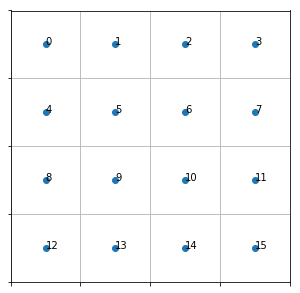

In [12]:
size = (4,4)
show_anchors(create_grid(size), size)

In [13]:
def create_anchors(sizes, ratios, scales, flatten=True):
    "Create anchor of `sizes`, `ratios` and `scales`."
    aspects = [[[s*math.sqrt(r), s*math.sqrt(1/r)] for s in scales] for r in ratios]
    aspects = torch.tensor(aspects).view(-1,2)
    anchors = []
    for h,w in sizes:
        #4 here to have the anchors overlap.
        sized_aspects = 4 * (aspects * torch.tensor([2/h,2/w])).unsqueeze(0)
        base_grid = create_grid((h,w)).unsqueeze(1)
        n,a = base_grid.size(0),aspects.size(0)
        ancs = torch.cat([base_grid.expand(n,a,2), sized_aspects.expand(n,a,2)], 2)
        anchors.append(ancs.view(h,w,a,4))
    return torch.cat([anc.view(-1,4) for anc in anchors],0) if flatten else anchors

In [14]:
ratios = [1/2,1,2]
#scales = [1,2**(-1/3), 2**(-2/3)]
scales = [1,2**(1/3), 2**(2/3)]
sizes = [(2**i,2**i) for i in range(5)]
sizes.reverse()
anchors = create_anchors(sizes, ratios, scales)

In [15]:
anchors.size()

torch.Size([3069, 4])

In [16]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_color = 12
cmap = get_cmap(num_color)
color_list = [cmap(float(x)) for x in range(num_color)]

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [17]:
def show_boxes(boxes):
    "Show the `boxes` (size by 4)"
    _, ax = plt.subplots(1,1, figsize=(5,5))
    ax.set_xlim(-1,1)
    ax.set_ylim(1,-1)
    for i, bbox in enumerate(boxes):
        bb = bbox.numpy()
        rect = [bb[1]-bb[3]/2, bb[0]-bb[2]/2, bb[3], bb[2]]
        draw_rect(ax, rect, color=color_list[i%num_color])
        draw_text(ax, [bb[1]-bb[3]/2,bb[0]-bb[2]/2], str(i), color=color_list[i%num_color])

In [18]:
def activ_to_bbox(acts, anchors, flatten=True):
    "Extrapolate bounding boxes on anchors from the model activations."
    if flatten:
        acts.mul_(acts.new_tensor([[0.1, 0.1, 0.2, 0.2]]))
        centers = anchors[...,2:] * acts[...,:2] + anchors[...,:2]
        sizes = anchors[...,2:] * torch.exp(acts[...,:2])
        return torch.cat([centers, sizes], -1)
    else: return [activ_to_bbox(act,anc) for act,anc in zip(acts, anchors)]
    return res

In [19]:

size=(3,4)
anchors = create_grid(size)
anchors = torch.cat([anchors, torch.tensor([2/size[0],2/size[1]]).expand_as(anchors)], 1)
activations = 0.1 * torch.randn(size[0]*size[1], 4)
bboxes = activ_to_bbox(activations, anchors)

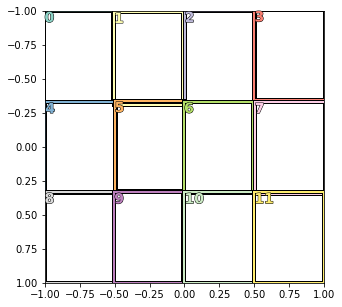

In [20]:
show_boxes(bboxes)

In [21]:
def cthw2tlbr(boxes):
    "Convert center/size format `boxes` to top/left bottom/right corners."
    top_left = boxes[:,:2] - boxes[:,2:]/2
    bot_right = boxes[:,:2] + boxes[:,2:]/2
    return torch.cat([top_left, bot_right], 1)

In [22]:
def intersection(anchors, targets):
    "Compute the sizes of the intersections of `anchors` by `targets`."
    ancs, tgts = cthw2tlbr(anchors), cthw2tlbr(targets)
    a, t = ancs.size(0), tgts.size(0)
    ancs, tgts = ancs.unsqueeze(1).expand(a,t,4), tgts.unsqueeze(0).expand(a,t,4)
    top_left_i = torch.max(ancs[...,:2], tgts[...,:2])
    bot_right_i = torch.min(ancs[...,2:], tgts[...,2:])
    sizes = torch.clamp(bot_right_i - top_left_i, min=0) 
    return sizes[...,0] * sizes[...,1]

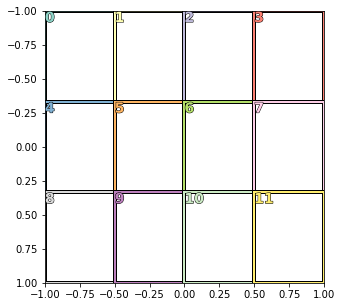

In [23]:
show_boxes(anchors)

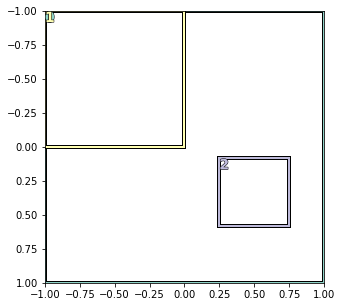

In [24]:
targets = torch.tensor([[0.,0.,2.,2.], [-0.5,-0.5,1.,1.], [1/3,0.5,0.5,0.5]])
show_boxes(targets)

In [25]:
intersection(anchors, targets)

tensor([[0.3333, 0.3333, 0.0000],
        [0.3333, 0.3333, 0.0000],
        [0.3333, 0.0000, 0.0000],
        [0.3333, 0.0000, 0.0000],
        [0.3333, 0.1667, 0.0000],
        [0.3333, 0.1667, 0.0000],
        [0.3333, 0.0000, 0.0625],
        [0.3333, 0.0000, 0.0625],
        [0.3333, 0.0000, 0.0000],
        [0.3333, 0.0000, 0.0000],
        [0.3333, 0.0000, 0.0625],
        [0.3333, 0.0000, 0.0625]])

In [26]:
def IoU_values(anchors, targets):
    "Compute the IoU values of `anchors` by `targets`."
    inter = intersection(anchors, targets)
    anc_sz, tgt_sz = anchors[:,2] * anchors[:,3], targets[:,2] * targets[:,3]
    union = anc_sz.unsqueeze(1) + tgt_sz.unsqueeze(0) - inter
    return inter/(union+1e-8)

In [27]:
IoU_values(anchors, targets)

tensor([[0.0833, 0.3333, 0.0000],
        [0.0833, 0.3333, 0.0000],
        [0.0833, 0.0000, 0.0000],
        [0.0833, 0.0000, 0.0000],
        [0.0833, 0.1429, 0.0000],
        [0.0833, 0.1429, 0.0000],
        [0.0833, 0.0000, 0.1200],
        [0.0833, 0.0000, 0.1200],
        [0.0833, 0.0000, 0.0000],
        [0.0833, 0.0000, 0.0000],
        [0.0833, 0.0000, 0.1200],
        [0.0833, 0.0000, 0.1200]])

In [28]:
def match_anchors(anchors, targets, match_thr=0.5, bkg_thr=0.4):
    "Match `anchors` to targets. -1 is match to background, -2 is ignore."
    ious = IoU_values(anchors, targets)
    matches = anchors.new(anchors.size(0)).zero_().long() - 2
    vals,idxs = torch.max(ious,1)
    matches[vals < bkg_thr] = -1
    matches[vals > match_thr] = idxs[vals > match_thr]
    #Overwrite matches with each target getting the anchor that has the max IoU.
    #vals,idxs = torch.max(ious,0)
    #If idxs contains repetition, this doesn't bug and only the last is considered.
    #matches[idxs] = targets.new_tensor(list(range(targets.size(0)))).long()
    return matches

In [29]:
match_anchors(anchors, targets)

tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [30]:
size=(3,4)
anchors = create_grid(size)
anchors = torch.cat([anchors, torch.tensor([2/size[0],2/size[1]]).expand_as(anchors)], 1)
activations = 0.1 * torch.randn(size[0]*size[1], 4)
bboxes = activ_to_bbox(activations, anchors)
match_anchors(anchors,bboxes)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [31]:
anchors = create_grid((2,2))
anchors = torch.cat([anchors, torch.tensor([1.,1.]).expand_as(anchors)], 1)
targets = anchors.clone()
anchors = torch.cat([anchors, torch.tensor([[-0.5,0.,1.,1.8]])], 0)
match_anchors(anchors,targets)

tensor([ 0,  1,  2,  3, -2])

In [32]:
def tlbr2cthw(boxes):
    "Convert top/left bottom/right format `boxes` to center/size corners."
    center = (boxes[:,:2] + boxes[:,2:])/2
    sizes = boxes[:,2:] - boxes[:,:2]
    return torch.cat([center, sizes], 1)

In [33]:
def bbox_to_activ(bboxes, anchors, flatten=True):
    "Return the target of the model on `anchors` for the `bboxes`."
    if flatten:
        t_centers = (bboxes[...,:2] - anchors[...,:2]) / anchors[...,2:] 
        t_sizes = torch.log(bboxes[...,2:] / anchors[...,2:] + 1e-8) 
        return torch.cat([t_centers, t_sizes], -1).div_(bboxes.new_tensor([[0.1, 0.1, 0.2, 0.2]]))
    else: return [activ_to_bbox(act,anc) for act,anc in zip(acts, anchors)]
    return res

In [34]:
def encode_class(idxs, n_classes):
    target = idxs.new_zeros(len(idxs), n_classes).float()
    mask = idxs != 0
    i1s = LongTensor(list(range(len(idxs))))
    target[i1s[mask],idxs[mask]-1] = 1
    return target

In [35]:
encode_class(LongTensor([1,2,0,1,3]),3)

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.]])

In [36]:
class RetinaNetFocalLoss(nn.Module):
    
    def __init__(self, gamma:float=2., alpha:float=0.25,  pad_idx:int=0, scales:Collection[float]=None, 
                 ratios:Collection[float]=None, reg_loss:LossFunction=F.smooth_l1_loss):
        super().__init__()
        self.gamma,self.alpha,self.pad_idx,self.reg_loss = gamma,alpha,pad_idx,reg_loss
        self.scales = ifnone(scales, [1,2**(-1/3), 2**(-2/3)])
        self.ratios = ifnone(ratios, [1/2,1,2])
        
    def _change_anchors(self, sizes:Sizes) -> bool:
        if not hasattr(self, 'sizes'): return True
        for sz1, sz2 in zip(self.sizes, sizes):
            if sz1[0] != sz2[0] or sz1[1] != sz2[1]: return True
        return False
    
    def _create_anchors(self, sizes:Sizes, device:torch.device):
        self.sizes = sizes
        self.anchors = create_anchors(sizes, self.ratios, self.scales).to(device)
    
    def _unpad(self, bbox_tgt, clas_tgt):
        i = torch.min(torch.nonzero(clas_tgt-self.pad_idx))
        return tlbr2cthw(bbox_tgt[i:]), clas_tgt[i:]-1+self.pad_idx
    
    def _focal_loss(self, clas_pred, clas_tgt):
        encoded_tgt = encode_class(clas_tgt, clas_pred.size(1))
        ps = torch.sigmoid(clas_pred)
        weights = encoded_tgt * (1-ps) + (1-encoded_tgt) * ps
        alphas = (1-encoded_tgt) * self.alpha + encoded_tgt * (1-self.alpha)
        weights.pow_(self.gamma).mul_(alphas)
        clas_loss = F.binary_cross_entropy_with_logits(clas_pred, encoded_tgt, weights, reduction='sum')
        return clas_loss
        
    def _one_loss(self, clas_pred, bbox_pred, clas_tgt, bbox_tgt):
        bbox_tgt, clas_tgt = self._unpad(bbox_tgt, clas_tgt)
        matches = match_anchors(self.anchors, bbox_tgt)
        bbox_mask = matches>=0
        if bbox_mask.sum() != 0:
            bbox_pred = bbox_pred[bbox_mask]
            bbox_tgt = bbox_tgt[matches[bbox_mask]]
            bb_loss = self.reg_loss(bbox_pred, bbox_to_activ(bbox_tgt, self.anchors[bbox_mask]))
        else: bb_loss = 0.
        matches.add_(1)
        clas_tgt = clas_tgt + 1
        clas_mask = matches>=0
        clas_pred = clas_pred[clas_mask]
        clas_tgt = torch.cat([clas_tgt.new_zeros(1).long(), clas_tgt])
        clas_tgt = clas_tgt[matches[clas_mask]]
        return bb_loss + self._focal_loss(clas_pred, clas_tgt)/torch.clamp(bbox_mask.sum(), min=1.)
    
    def forward(self, output, bbox_tgts, clas_tgts):
        clas_preds, bbox_preds, sizes = output
        if self._change_anchors(sizes): self._create_anchors(sizes, clas_preds.device)
        n_classes = clas_preds.size(2)
        return sum([self._one_loss(cp, bp, ct, bt)
                    for (cp, bp, ct, bt) in zip(clas_preds, bbox_preds, clas_tgts, bbox_tgts)])/clas_tgts.size(0)

In [37]:
class SigmaL1SmoothLoss(nn.Module):

    def forward(self, output, target):
        reg_diff = torch.abs(target - output)
        reg_loss = torch.where(torch.le(reg_diff, 1/9), 4.5 * torch.pow(reg_diff, 2), reg_diff - 1/18)
        return reg_loss.mean()

In [38]:
tgt_clas = LongTensor([[1,2], [3,4]])
tgt_bbox = FloatTensor([[[0,0,128,64], [64,32,128,128]], [[96,128,192,256], [192,96,256,128]]])
tgt_bbox = tgt_bbox / 128 - 1.
y = [tgt_bbox.cuda(), tgt_clas.cuda()]

In [39]:
n_classes = data.train_ds.c

crit = RetinaNetFocalLoss(anchors)

encoder = create_body(models.resnet50, True, -2)
model = RetinaNet(encoder, n_classes=data.train_ds.c, n_anchors=18, sizes=[32,16,8,4], chs=32, final_bias=-4., n_conv=2)

In [43]:
learn = Learner(data,model.cuda(),loss_func=crit)

In [44]:
learn.split(lambda m: (m.encoder[6],m.c5top5));
#learn.to_fp16();
learn.freeze_to(-1);

In [45]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


IndexError: The shape of the mask [12240] at index 0 does not match the shape of the indexed tensor [24480, 4] at index 0